1. [Аффинные преобразования](#1.-Аффинные-преобразования)
1. [LookUp Table](#2.-LookUp-Table)
1. [Перевод в цветовую схему](#3.-Перевод-в-цветовую-схему)
1. [Матричные фильтры обработки изображений](#4.-Матричные-фильтры-обработки-изображений)
1. [Кодирование кривых при помощи трёхразрядного кода](#5.-Кодирование-кривых-при-помощи-трёхразрядного-кода)

## 1. Аффинные преобразования

In [1]:
import cv2
from matplotlib import lines
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
class Triangle:
    def __init__(self, xA, yA, xB, yB, xC, yC):
        self.xA = xA
        self.yA = yA
        self.xB = xB
        self.yB = yB
        self.xC = xC
        self.yC = yC
    
    def plot(self, title):
        """Рисует треугольник."""
        ax = plt.subplot()
        ax.plot([self.xA, self.xB, self.xC, self.xA], [self.yA, self.yB, self.yC, self.yA])
        ax.text(self.xA, self.yA, f'A ({self.xA:2.2}, {self.yA:2.2})', fontsize='large')
        ax.text(self.xB, self.yB, f'B ({self.xB:2.2}, {self.yB:2.2})', fontsize='large')
        ax.text(self.xC, self.yC, f'C ({self.xC:2.2}, {self.yC:2.2})', fontsize='large')
        ax.set_title(title)
        ax.grid()
        plt.show()
    
    def flip(self, mode):
        """Отражает треугольник.
        
        Args:
            mode: относительно какой оси отражать.
              'x': относительно X;
              'y': относительно Y;
              'xy': относительно обеих осей;
              'yx': относительно обеих осей.
        """
        if mode == 'x':
            self.xA = -self.xA
            self.xB = -self.xB
            self.xC = -self.xC
        elif mode == 'y':
            self.yA = -self.yA
            self.yB = -self.yB
            self.yC = -self.yC
        elif mode in ('xy', 'yx'):
            self.xA = -self.xA
            self.xB = -self.xB
            self.xC = -self.xC
            self.yA = -self.yA
            self.yB = -self.yB
            self.yC = -self.yC
    
    def shift(self, direction, size):
        """Сдвигает треугольник.
        
        Args:
            direction: направление.
            size: размер сдвига.
        """
        if direction == 'наверх':
            self.yA += size
            self.yB += size
            self.yC += size
        elif direction == 'вниз':
            self.yA -= size
            self.yB -= size
            self.yC -= size
        elif direction == 'вправо':
            self.xA += size
            self.xB += size
            self.xC += size
        elif direction == 'влево':
            self.xA -= size
            self.xB -= size
            self.xC -= size

    def transform(self, a=1, b=1):
        """Трансформирует треугольник.
        
        Args:
            a: коэффициент растяжения/сжатия по оси X.
            b: коэффициент растяжения/сжатия по оси Y.
        """
        self.xA *= a
        self.xB *= a
        self.xC *= a

        self.yA *= b
        self.yB *= b
        self.yC *= b
    
    def rotation(self, apex, alpha):
        """Поворачивает треугольник относительно вершины на угол alpha."""
        tmp_xA = self.xA
        tmp_xB = self.xB
        tmp_xC = self.xC
        tmp_yA = self.yA
        tmp_yB = self.yB
        tmp_yC = self.yC
        
        if apex == 'A':
            x0 = self.xA
            y0 = self.yA
        elif apex == 'B':
            x0 = self.xB
            y0 = self.yB
        elif apex == 'C':
            x0 = self.xC
            y0 = self.yC
        
        self.xA = (tmp_xA - x0) * np.cos(alpha) - (tmp_yA - y0) * np.sin(alpha) + x0
        self.xB = (tmp_xB - x0) * np.cos(alpha) - (tmp_yB - y0) * np.sin(alpha) + x0
        self.xC = (tmp_xC - x0) * np.cos(alpha) - (tmp_yC - y0) * np.sin(alpha) + x0
        
        self.yA = (tmp_xA - x0) * np.sin(alpha) + (tmp_yA - y0) * np.cos(alpha) + y0
        self.yB = (tmp_xB - x0) * np.sin(alpha) + (tmp_yB - y0) * np.cos(alpha) + y0
        self.yC = (tmp_xC - x0) * np.sin(alpha) + (tmp_yC - y0) * np.cos(alpha) + y0

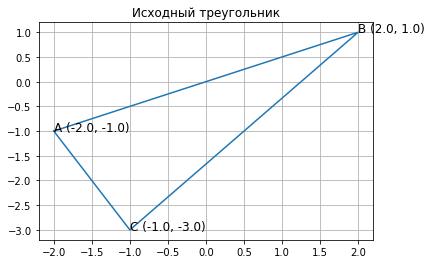

In [3]:
triangle = Triangle(-2., -1., 2., 1., -1., -3.)
triangle.plot('Исходный треугольник')

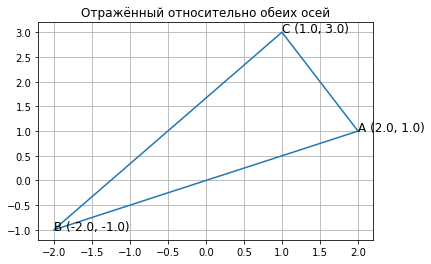

In [4]:
triangle.flip('xy')
triangle.plot('Отражённый относительно обеих осей')

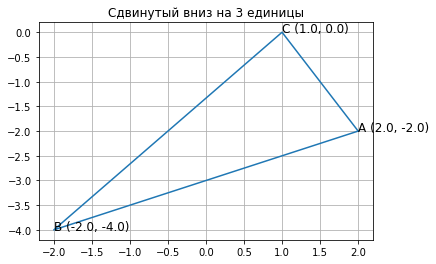

In [5]:
triangle.shift('вниз', 3)
triangle.plot('Сдвинутый вниз на 3 единицы')

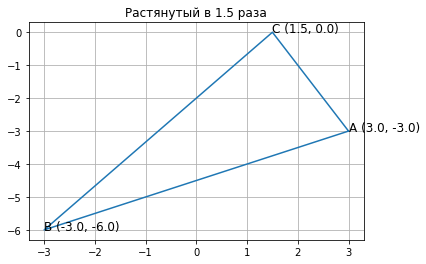

In [6]:
triangle.transform(a=1.5, b=1.5)
triangle.plot('Растянутый в 1.5 раза')

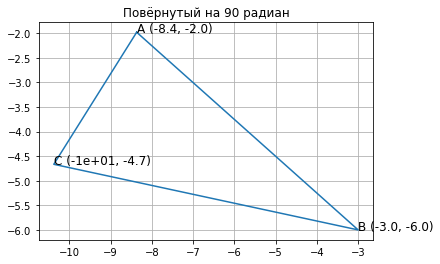

In [7]:
triangle.rotation('B', 90)
triangle.plot('Повёрнутый на 90 радиан')

## 2. LookUp Table

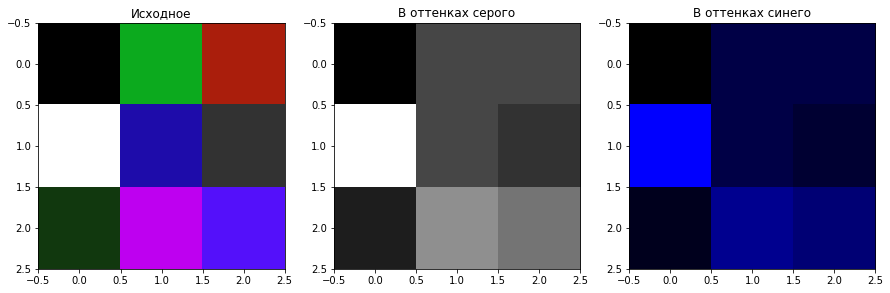

In [8]:
BLUE_TABLE = [0, 0, 1]


def rgb_to_gray(image):
    """Конвертирует изображение из RGB в оттенки серого."""
    gray_image = []
    for line in image:
        gray_line = []
        for pixel in line:
            gray = int((pixel[0] + pixel[1] + pixel[2]) / 3)
            gray_pixel = [gray, gray, gray]
            gray_line.append(gray_pixel)
        gray_image.append(gray_line)
    return gray_image


def gray_to_lut(gray_image, table):
    """Конвертирует изображение из оттенков серого в LUT."""
    lut_image = []
    for line in gray_image:
        lut_line = []
        for pixel in line:
            lut_pixel = [a * b for a, b in zip(pixel, table)]
            lut_line.append(lut_pixel)
        lut_image.append(lut_line)
    return lut_image


image = [[[  0,   0,   0], [12, 170,  30], [170, 30,  12]],
         [[255, 255, 255], [30,  12, 170], [ 50, 50,  50]],
         [[ 17,  56,  14], [190,  0, 240], [ 84, 16, 250]]]

grayscale_image = rgb_to_gray(image)
lut_image = gray2lut(grayscale_image, BLUE_TABLE)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title('Исходное')
axes[1].imshow(grayscale_image)
axes[1].set_title('В оттенках серого')
axes[2].imshow(lut_image)
axes[2].set_title('В оттенках синего')
plt.show()

## 3. Перевод в цветовую схему

In [9]:
image = np.array([[[  0,   0,   0], [12, 170,  30], [170, 30,  12]],
                  [[255, 255, 255], [30,  12, 170], [ 50, 50,  50]],
                  [[ 17,  56,  14], [190,  0, 240], [ 84, 16, 250]]])

YCbCr = np.array([[ 65.481, 128.553,   24.966],
                  [-37.797, -74.203,  112.0],
                  [112.0,   -93.786, -18.214]])


def rgb_to_ycbcr(image):
    """Конвертирует изображение из RGB d YCBCR."""
    ycbcr_image = []
    for line in image:
        ycbcr_line = []
        for pixel in line:
            ycbcr_pixel = list(YCbCr.dot(pixel))
            ycbcr_line.append(ycbcr_pixel)
        ycbcr_image.append(ycbcr_line)
    return ycbcr_image


ycbcr_image = rgb2ycbcr(image)
print(ycbcr_image)

[[[0.0, 0.0, 0.0], [23388.762, -9708.074, -15146.04], [15287.952, -7307.58, 16007.852]], [[55845.0, 0.0, 0.0], [7751.286, 17015.654, -861.8119999999997], [10950.0, 0.0, 0.0]], [[8661.669, -3229.9170000000004, -3603.0119999999997], [18433.23, 19698.57, 16908.64], [13798.751999999999, 23637.804, 3353.924]]]


## 4. Матричные фильтры обработки изображений

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


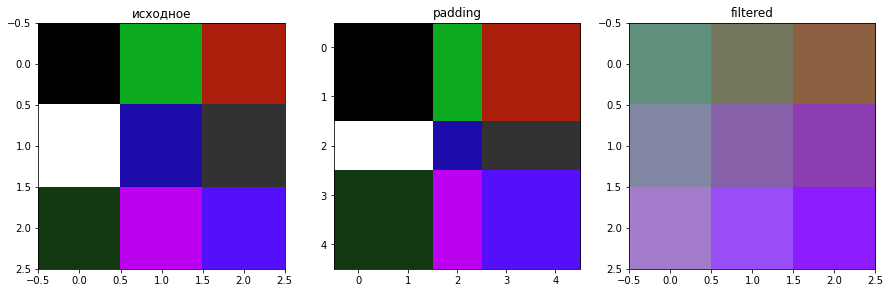

In [10]:
IMAGE = np.array([[[  0,   0,   0], [12, 170,  30], [170, 30,  12]],
                  [[255, 255, 255], [30,  12, 170], [ 50, 50,  50]],
                  [[ 17,  56,  14], [190,  0, 240], [ 84, 16, 250]]], dtype='int16')
KERNEL = np.ones((3, 3), np.float32) / 6


def padding(image):
    """Дополняет изображение отступом."""
    new_image = []
    for line in image:
        new_line = [line[0]] + list(line) + [line[-1]]
        new_image.append(new_line)
    new_image = [new_image[0]] + list(new_image) + [new_image[-1]]
    return np.array(new_image, dtype='int16')


pad_image = padding(IMAGE)
filtered = cv2.filter2D(IMAGE, -1, KERNEL, borderType=cv2.BORDER_REPLICATE)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(IMAGE)
axes[0].set_title('исходное')
axes[1].imshow(pad_image)
axes[1].set_title('padding')
axes[2].imshow(filtered)
axes[2].set_title('filtered')
plt.show()

## 5. Кодирование кривых при помощи трёхразрядного кода

In [11]:
START_X = -3
STOP_X = 0.7
N = 201

xlist = np.linspace(START_X, STOP_X, N)
ylist = pow(xlist, 2) * np.exp(3 * xlist)

f = lambda x: pow(x, 2) * np.exp(3 * x)


def plot_square(x, y):
    ax = plt.subplot()
    ax.grid()
    ax.plot(xlist, ylist)
    # горизонтальные линии
    ax.plot([x-1.5, x+1.5], [y+1.5, y+1.5], color='green')
    ax.plot([x-1.5, x+1.5], [y+0.5, y+0.5], color='green')
    ax.plot([x-1.5, x+1.5], [y-0.5, y-0.5], color='green')
    ax.plot([x-1.5, x+1.5], [y-1.5, y-1.5], color='green')
    # вертикальные линии
    ax.plot([x-1.5, x-1.5], [y+1.5, y-1.5], color='green')
    ax.plot([x-0.5, x-0.5], [y+1.5, y-1.5], color='green')
    ax.plot([x+0.5, x+0.5], [y+1.5, y-1.5], color='green')
    ax.plot([x+1.5, x+1.5], [y+1.5, y-1.5], color='green')
    # точка
    ax.scatter(x, y, color='red')
    # цифры
    ax.text(x+1, y, '0')
    ax.text(x+1, y-1, '1')
    ax.text(x, y-1, '2')
    ax.text(x-1, y-1, '3')
    ax.text(x-1, y, '4')
    ax.text(x-1, y+1, '5')
    ax.text(x, y+1, '6')
    ax.text(x+1, y+1, '7')
    plt.show()

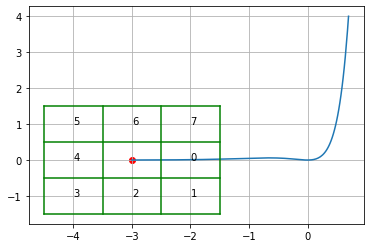

In [12]:
start_x = START_X
start_y = f(start_x)
plot_square(start_x, start_y)

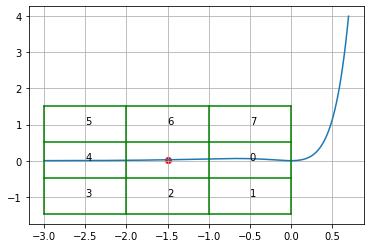

In [13]:
plot_square(start_x+1.5, f(start_x+1.5))

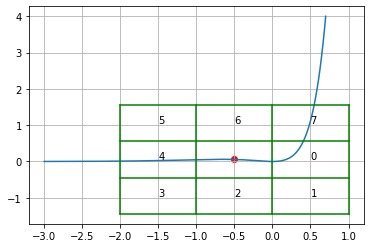

In [14]:
plot_square(start_x+2.5, f(start_x+2.5))